In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [2]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [3]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [4]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [5]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [6]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])
print(x_train.shape)

(1777, 1, 2000)


In [12]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_test)
print(len(y_test))

[[[[1. 0.]
   [0. 1.]]

  [[0. 1.]
   [1. 0.]]]


 [[[0. 1.]
   [1. 0.]]

  [[1. 0.]
   [0. 1.]]]


 [[[1. 0.]
   [0. 1.]]

  [[0. 1.]
   [1. 0.]]]


 ...


 [[[0. 1.]
   [1. 0.]]

  [[1. 0.]
   [0. 1.]]]


 [[[0. 1.]
   [1. 0.]]

  [[1. 0.]
   [0. 1.]]]


 [[[0. 1.]
   [1. 0.]]

  [[1. 0.]
   [0. 1.]]]]
445


In [92]:
# 构建网络
model = Sequential() 

model.add(Conv1D(128,16, activation='relu', padding='same'))
model.add(Conv1D(128,8, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, padding='same'))


model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

model.build(input_shape=x_train.shape)
model.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           multiple                  4096128   
_________________________________________________________________
conv1d_47 (Conv1D)           multiple                  131200    
_________________________________________________________________
batch_normalization_69 (Batc multiple                  512       
_________________________________________________________________
max_pooling1d_23 (MaxPooling multiple                  0         
_________________________________________________________________
bidirectional_46 (Bidirectio multiple                  98816     
_________________________________________________________________
batch_normalization_70 (Batc multiple                  512       
_________________________________________________________________
bidirectional_47 (Bidirectio multiple                

In [94]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V8_12.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9882
Epoch 00001: val_accuracy improved from -inf to 0.72584, saving model to BiLSTM_V8_12.h5
28/28 [==============================] - 4s 139ms/step - loss: 0.0436 - accuracy: 0.9882 - val_loss: 1.0398 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9854
Epoch 00002: val_accuracy did not improve from 0.72584
28/28 [==============================] - 3s 109ms/step - loss: 0.0437 - accuracy: 0.9854 - val_loss: 1.5154 - val_accuracy: 0.6225 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9899
Epoch 00003: val_accuracy did not improve from 0.72584
28/28 [==============================] - 3s 110ms/step - loss: 0.0289 - accuracy: 0.9899 - val_loss: 7.1633 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - ETA: 0s - loss: 0.0345 - accura

28/28 [==============================] - ETA: 0s - loss: 7.9926e-04 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.82472
28/28 [==============================] - 3s 110ms/step - loss: 7.9926e-04 - accuracy: 1.0000 - val_loss: 1.0859 - val_accuracy: 0.7326 - lr: 5.0000e-04
Epoch 56/200
28/28 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 00056: val_accuracy improved from 0.82472 to 0.83820, saving model to BiLSTM_V8_12.h5
28/28 [==============================] - 3s 113ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.1154 - val_accuracy: 0.8382 - lr: 5.0000e-04
Epoch 57/200
28/28 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9972
Epoch 00057: val_accuracy did not improve from 0.83820
28/28 [==============================] - 3s 113ms/step - loss: 0.0064 - accuracy: 0.9972 - val_loss: 0.6798 - val_accuracy: 0.8090 - lr: 5.0000e-04
Epoch 58/200
28/28 [==============================] - ETA: 0s - loss: 0

Epoch 82/200
28/28 [==============================] - ETA: 0s - loss: 4.0282e-04 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.91011
28/28 [==============================] - 3s 102ms/step - loss: 4.0282e-04 - accuracy: 1.0000 - val_loss: 0.5991 - val_accuracy: 0.9079 - lr: 5.0000e-04
Epoch 83/200
28/28 [==============================] - ETA: 0s - loss: 2.9372e-04 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.91011
28/28 [==============================] - 3s 102ms/step - loss: 2.9372e-04 - accuracy: 1.0000 - val_loss: 0.8283 - val_accuracy: 0.8989 - lr: 5.0000e-04
Epoch 84/200
28/28 [==============================] - ETA: 0s - loss: 1.9428e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.91011

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
28/28 [==============================] - 3s 104ms/step - loss: 1.9428e-04 - accuracy: 1.0000 - val_loss: 0.6892 - val_accuracy: 0.9101 - lr: 5.0000e-0

28/28 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994
Epoch 00134: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 111ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 1.3322 - val_accuracy: 0.7753 - lr: 1.2500e-04
Epoch 135/200
28/28 [==============================] - ETA: 0s - loss: 3.8277e-04 - accuracy: 1.0000
Epoch 00135: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 112ms/step - loss: 3.8277e-04 - accuracy: 1.0000 - val_loss: 0.5888 - val_accuracy: 0.9011 - lr: 1.2500e-04
Epoch 136/200
28/28 [==============================] - ETA: 0s - loss: 1.5882e-04 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 111ms/step - loss: 1.5882e-04 - accuracy: 1.0000 - val_loss: 0.5358 - val_accuracy: 0.9146 - lr: 1.2500e-04
Epoch 137/200
28/28 [==============================] - ETA: 0s - loss: 1.3612e-04 - accuracy: 1.00

Epoch 161/200
28/28 [==============================] - ETA: 0s - loss: 3.9758e-05 - accuracy: 1.0000
Epoch 00161: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 110ms/step - loss: 3.9758e-05 - accuracy: 1.0000 - val_loss: 0.5903 - val_accuracy: 0.9079 - lr: 6.2500e-05
Epoch 162/200
28/28 [==============================] - ETA: 0s - loss: 5.1510e-05 - accuracy: 1.0000
Epoch 00162: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 112ms/step - loss: 5.1510e-05 - accuracy: 1.0000 - val_loss: 0.5695 - val_accuracy: 0.9056 - lr: 6.2500e-05
Epoch 163/200
28/28 [==============================] - ETA: 0s - loss: 7.1501e-05 - accuracy: 1.0000
Epoch 00163: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 111ms/step - loss: 7.1501e-05 - accuracy: 1.0000 - val_loss: 0.5497 - val_accuracy: 0.9101 - lr: 6.2500e-05
Epoch 164/200
28/28 [==============================] - ETA: 0s - loss: 2.245

Epoch 188/200
28/28 [==============================] - ETA: 0s - loss: 3.3244e-04 - accuracy: 1.0000
Epoch 00188: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 109ms/step - loss: 3.3244e-04 - accuracy: 1.0000 - val_loss: 0.5171 - val_accuracy: 0.9258 - lr: 1.5625e-05
Epoch 189/200
28/28 [==============================] - ETA: 0s - loss: 1.3435e-04 - accuracy: 1.0000
Epoch 00189: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 110ms/step - loss: 1.3435e-04 - accuracy: 1.0000 - val_loss: 0.5164 - val_accuracy: 0.9213 - lr: 1.5625e-05
Epoch 190/200
28/28 [==============================] - ETA: 0s - loss: 8.9025e-05 - accuracy: 1.0000
Epoch 00190: val_accuracy did not improve from 0.92809
28/28 [==============================] - 3s 111ms/step - loss: 8.9025e-05 - accuracy: 1.0000 - val_loss: 0.5605 - val_accuracy: 0.9191 - lr: 1.5625e-05
Epoch 191/200
28/28 [==============================] - ETA: 0s - loss: 7.787

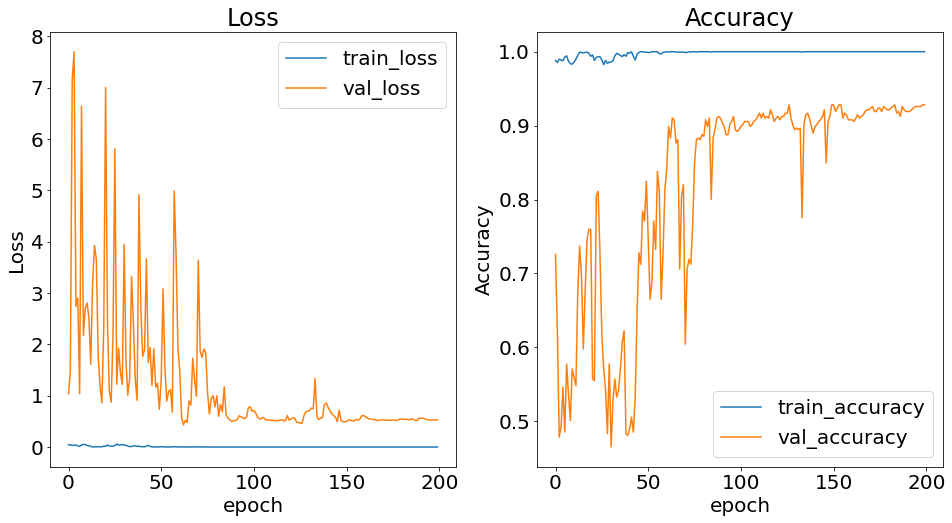

In [95]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [8]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V8_12.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [9]:
print(y_test_pred)

[[9.76354480e-01 2.36455351e-02]
 [9.99999762e-01 2.94444362e-07]
 [9.99999881e-01 1.41590235e-07]
 [9.98487711e-01 1.51224679e-03]
 [9.99993086e-01 6.89213812e-06]
 [8.21141466e-09 1.00000000e+00]
 [9.99994040e-01 5.90427317e-06]
 [9.99949694e-01 5.03106494e-05]
 [4.26055485e-04 9.99573886e-01]
 [9.98412251e-01 1.58771162e-03]
 [9.99982595e-01 1.73482113e-05]
 [2.89013428e-06 9.99997139e-01]
 [1.43490775e-04 9.99856472e-01]
 [9.99966264e-01 3.36807425e-05]
 [1.59518828e-03 9.98404801e-01]
 [1.51664437e-06 9.99998450e-01]
 [9.99999404e-01 5.45743660e-07]
 [9.99997497e-01 2.50324138e-06]
 [9.99998093e-01 1.93247752e-06]
 [9.99020219e-01 9.79741686e-04]
 [9.99999285e-01 7.65172160e-07]
 [3.84364175e-05 9.99961615e-01]
 [4.63976800e-01 5.36023200e-01]
 [2.65279610e-04 9.99734700e-01]
 [9.99995708e-01 4.28963995e-06]
 [6.05828973e-07 9.99999404e-01]
 [9.99999881e-01 6.22201668e-08]
 [9.80341338e-06 9.99990225e-01]
 [9.99997973e-01 2.06607274e-06]
 [9.99955535e-01 4.44701000e-05]
 [7.795273

In [10]:
print(y_test)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 

In [97]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 1.0% 召回率:  1.0, f1:  1.0
在20%测试集上, accuracy: 0.9281% 召回率: 0.9623430962343096, f1: 0.9349593495934958


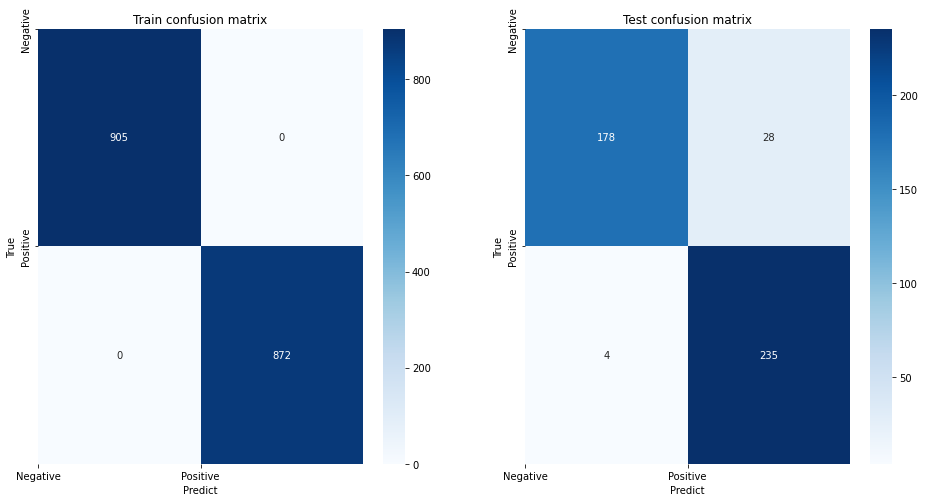

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()